In [1]:
import numpy as np
import pandas as pd
import scipy.stats as stats

from matplotlib import pyplot as plt
import seaborn as sns

from tqdm import tqdm

In [2]:
sns.set()

In [3]:
from scipy.stats import norm, expon, gamma, chi2, chisquare, chi2_contingency, \
    randint, kstest, poisson, binom
from statsmodels.stats.proportion import proportion_confint  

В параграфе про критерий Колмогорова мы разобрали как проверять простую гипотезу в случае, когда ф.р. непрерывна, а так же показали, что для дискретных распределений критерий не работает.  
Данная глава посвящена тому, чтобы окончательно закрыть вопрос с простой гипотезой, а так же добавить ещё несколько слов про сложную

Задача: хотим проверить игральный кубик на честность   
Пусть $p_i$ - вероятности выпадения грани $i$, тогда постановка задачи выглядит следующим образом   
$$
H_0: p_1 = p_2 = p_3 = p_4 = p_5 = p_6 = \frac{1}{6}
$$

$$
H_1: H_0\text{ неверна}
$$

Пусть мы кинули кубик $n$ раз, тогда можем составить таблицу частот (frequency table) 
|$a_i$|1|2|3|4|5|6|
|---|---|---|---|---|---|---|
|$n_i$|5|8|9|8|10|20|

Интуиция подсказывает, что 6 не должно выпадать так часто, но надо проверить не шум ли это. Для этого составим статистику  
$$\tau = n\sum_i\frac{\left( \frac{n_i}{n}-p_i \right) ^2}{p_i}$$

Гдн $n_i$ - частота выпадения значения $i$, $n$ - число бросков, $p_i$ - ожидаемая вероятность выпадения значения $i$ (для составления такой статистики есть довольно понятные предпосылки - $(\frac{n_i}{n} - p_i)$ - разница между истинной вероятностью и эмпирической, в квадрат возводим чтобы получилось положительное число(взять модуль не самая хорошая идея, потому что с не гладкой функцией тяжелее работать при оценке предельного распределения), делим на $p_i$ чтобы отнормировать верхнее значение, умножаем на n чтобы сумма не стремилась к нулю по узбч, а имела какое-то предельное распределение)

Тогда, как доказал одныжды Пирсон, имеет место следующее поведение на бесконечности  
$$\tau \overset{d} \rightarrow \chi^2_{k - 1}$$

Построим график, подтверждающий эту теорему и применим критерия Колмогорова для проверки (для проверки через критерий пришлось увеличить объём выборки, так как иначе в таблице появлялось много ячеек со значениями < 5, для них приближение через хи-квадрат работает плохо)

In [67]:
dist = randint(1, 7)
N_expr = 10_000
sample_size = 200

stat = np.empty(N_expr)

for i in tqdm(range(N_expr)):
    sample = dist.rvs(sample_size)
    ft = np.array([np.count_nonzero(sample == i) for i in range(1, 7)])
    stat[i] = sample_size * sum([(ft[i - 1] / sample_size - dist.pmf(i)) ** 2 / dist.pmf(i) for i in range(1, 7)])

100%|██████████| 10000/10000 [00:13<00:00, 758.76it/s]


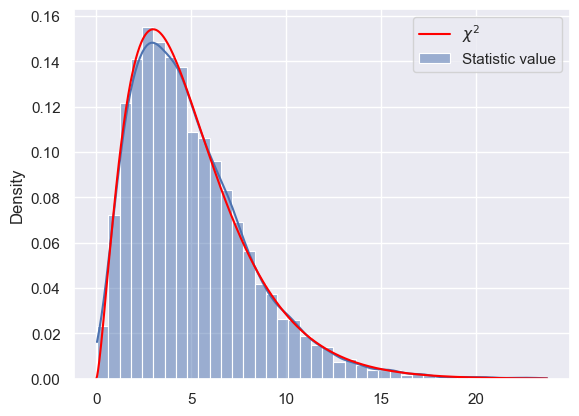

In [68]:
fig, ax = plt.subplots()

sns.histplot(stat, kde=True, ax=ax, stat='density', bins=40, label=r'Statistic value')

x = np.linspace(0, stat.max(), 1000)
ax.plot(x, chi2.pdf(x, df = 6 - 1), color='red', label=r'$\chi^2$')

ax.legend()

In [69]:
D, pvalue = kstest(stat, cdf=chi2(df=6 - 1).cdf)
pvalue

0.4208326732542996

Посмотрим на распределение хи-квадрат при разном числе степеней свободы

(0.0, 0.4)

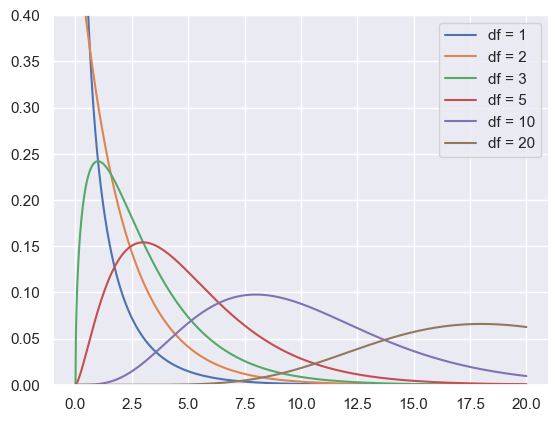

In [162]:
x = np.linspace(0, 20, 1000)
fig, ax = plt.subplots()

for i in (1, 2, 3, 5, 10, 20):
    ax.plot(x, chi2(df=i).pdf(x), label=f'df = {i}')

ax.legend()
ax.set_ylim(0, 0.4)

Итого, пользуясь теоремой Пирсона и его же рекомендациями по применению критерия, можно записать следующий алгоритм:

1. Фиксируем уровень значимости $\alpha$.
2. Фиксируем дискретное распределение $\mathcal{P}$, на принадлежность к которому мы хотим проверить нашу выборку.
3. Записываем выборку с $k$ исходами в виде frequency table.
4. Если в ячейке таблицы стоит число <5 (либо <10 для случая frequency table 2x1), то объединяем исходы до тех пор, пока это условие не будет выполнено.
5. Рассчитываем статистику $$\tau = n\sum_{i=1}^k\frac{\left(\frac{n_i}{n}-p_i\right)^2}{p_i},$$
где $n$ - размер выборки, $k$ - число различных исходов, $n_i$ - число выпадений исхода $i$, $p_i$ - вероятность исхода $i$ согласно распределению $\mathcal{P}$.
6. Считаем $\it{\text{p-value}}$ как $P(X \geq \tau)$, где $X \sim \chi^2_{k-1}$.
7. Если $\it{\text{p-value}} \leq \alpha$, то гипотезу отвергаем.

Условия применимости:
- распределение дискретное;
- число наблюдений в каждой ячейке выше 5;
- для случая frequency table 2x1 число наблюдений в каждой ячейке выше 10.

Вооружившись новыми знаниями, можем проверить нашего крупье на честность

In [72]:
frequencies = [5, 8, 9, 8, 10, 20]
tau = 60 * sum([(f / 60 - 1/6) ** 2 / (1/6) for f in frequencies])
tau

13.4

In [73]:
1 - chi2.cdf(x=tau, df=6 - 1)

0.019905220334774376

In [74]:
chisquare(f_obs=frequencies, f_exp=[10 for _ in range(6)])

Power_divergenceResult(statistic=13.4, pvalue=0.01990522033477438)

То есть наш противник на уровне значимости 5% жульничает

Проверим, что критерий работает корректно

In [4]:
def check_criterion(sample_size, sample_dist, check_dist, crit, alpha=0.05, N_exps=10_000):
    
    positive=0

    for i in tqdm(range(N_exps), leave=False):
        sample = sample_dist.rvs(sample_size)

        pval = crit(sample, check_dist)

        positive += (pval < alpha)

    rate = positive / N_exps
    left, right = proportion_confint(count = positive, nobs = N_exps, alpha=alpha, method='wilson')

    return rate, left, right

In [5]:
def chisquare_for_check(sample, dist):
    unique_elements, freq = np.unique(sample, return_counts=True)
    expected = np.array([dist.pmf(elem) * len(sample) for elem in unique_elements])
    expected[-1] = len(sample) - expected[:-1].sum()
    return chisquare(f_obs=freq, f_exp=expected).pvalue


In [102]:
fpr, left, right = check_criterion(
    sample_size=60,
    sample_dist=randint(1, 6),
    check_dist=randint(1, 6),
    crit=chisquare_for_check
)
print('FPR: ', fpr)
print('FPR confint: ', (left, right))

FPR:  0.0503
FPR confint:  (0.04618626511967923, 0.05475910301490729)


In [108]:
fpr, left, right = check_criterion(
    sample_size=60,
    sample_dist=randint(1, 20),
    check_dist=randint(1, 20),
    crit=chisquare_for_check
)
print('FPR: ', fpr)
print('FPR confint: ', (left, right))

FPR:  0.0472
FPR confint:  (0.04321461148733595, 0.051533137437148754)


In [107]:
fpr, left, right = check_criterion(
    sample_size=60,
    sample_dist=randint(1, 40),
    check_dist=randint(1, 40),
    crit=chisquare_for_check
)
print('FPR: ', fpr)
print('FPR confint: ', (left, right))

FPR:  0.1944
FPR confint:  (0.18676162726692763, 0.20227307253722987)


In [109]:
fpr, left, right = check_criterion(
    sample_size=60,
    sample_dist=poisson(5),
    check_dist=poisson(5),
    crit=chisquare_for_check
)
print('FPR: ', fpr)
print('FPR confint: ', (left, right))

FPR:  0.0657
FPR confint:  (0.061008892331753314, 0.07072464865301638)


In [113]:
fpr, left, right = check_criterion(
    sample_size=200,
    sample_dist=poisson(5),
    check_dist=poisson(5),
    crit=chisquare_for_check
)
print('FPR: ', fpr)
print('FPR confint: ', (left, right))

FPR:  0.0549
FPR confint:  (0.05060400056424119, 0.0595378347853351)


In [114]:
fpr, left, right = check_criterion(
    sample_size=300,
    sample_dist=binom(n=30, p=0.8),
    check_dist=binom(n=30, p=0.8),
    crit=chisquare_for_check
)
print('FPR: ', fpr)
print('FPR confint: ', (left, right))

FPR:  0.1308
FPR confint:  (0.12433288451925537, 0.13755065987765222)


Видим, что критерий действительно плохо, когда много ячеек в таблице мало заполнены. Поэтому нужно объединять маленькие корзинки вместе

In [6]:
def merge_elems(freq, expected):
    mask = freq >= 5
    
    good_freq = freq[mask]
    good_expected = expected[mask]

    freq_res, exp_res = [], []
    cur_sum, cur_exp = 0, 0
    for f, e in zip(freq[~mask], expected[~mask]):
        if cur_sum + f >= 5:
            freq_res.append(cur_sum + f)
            exp_res.append(cur_exp + e)
            cur_sum, cur_exp = 0, 0
        else:
            cur_sum += f
            cur_exp += e

    if cur_sum != 0:
        if len(freq_res) != 0:
            freq_res[-1] += cur_sum
            exp_res[-1] += cur_exp
        else:
            good_freq[-1] += cur_sum
            good_expected[-1] += cur_exp

    
    return np.concatenate((good_freq, np.array(freq_res))), np.concatenate((good_expected, np.array(exp_res)))


def chisquare_for_check_merge(sample, dist):
    unique_elements, freq = np.unique(sample, return_counts=True)
    expected = np.array([dist.pmf(elem) * len(sample) for elem in unique_elements])
    expected[-1] = len(sample) - expected[:-1].sum()

    freq, expected = merge_elems(freq, expected)

    return chisquare(f_obs=freq, f_exp=expected).pvalue


In [147]:
fpr, left, right = check_criterion(
    sample_size=60,
    sample_dist=randint(1, 40),
    check_dist=randint(1, 40),
    crit=chisquare_for_check_merge
)
print('FPR: ', fpr)
print('FPR confint: ', (left, right))

  0%|          | 0/10000 [00:00<?, ?it/s]

FPR:  0.5889
FPR confint:  (0.5792239779639219, 0.5985077471257718)


In [151]:
fpr, left, right = check_criterion(
    sample_size=60,
    sample_dist=poisson(5),
    check_dist=poisson(5),
    crit=chisquare_for_check_merge
)
print('FPR: ', fpr)
print('FPR confint: ', (left, right))

FPR:  0.0905
FPR confint:  (0.08503305524730385, 0.09628143941828025)


In [145]:
fpr, left, right = check_criterion(
    sample_size=300,
    sample_dist=binom(n=30, p=0.8),
    check_dist=binom(n=30, p=0.8),
    crit=chisquare_for_check_merge,
)
print('FPR: ', fpr)
print('FPR confint: ', (left, right))

FPR:  0.06308
FPR confint:  (0.061589955088585134, 0.06460361182571443)


FPR всё ещё выше заявляенных 5%, хотя он и улучшился в некоторых случаях(в некоторых наоброт - ухудшился) но это уже можно объяснить тем, что мы теряем часть данных при слиянии ячеек таблицы, в итоге критерий проводится как бы по выборке меньшего размера, что, естественно, приводит к такому результаты.

Далее обсудим вопрос применимости критерия хи-квадрат для непрерывных распределений: если есть некоторое непрерывное распределение, то числовую ось можно разбить на $n$ промежутков равной вероятностной массы $1/n$, тогда по реализации этой случайной величины можем построить реализацию некоторой дискретной случайной величины, приближающей исходную абсолютно непрерывную. Тут в игру и вступает критерий хи-квадрат

Тогда у нас есть целый пак различных критериев: критерий Колмогорова, критерий хи-квадрат Пирсона для различных $n$, и как же понять какой из них лучше? Как обычно - методом Монте-Карло. Так как мы будем разбивать прямую на промежутки равной длины и брать достаточно большую выборку, не будем пытаться слить ячейки с малым количеством элементов(ожидаем, что в каждой ячейке будет $\frac{1}{n}$ от объёма выборки)

In [7]:
def check_criterion_continuous(sample_size, bins_amount, sample_dist, \
                               check_dist, crit, alpha=0.05, N_exps=10_000):
    
    positive=0
    bins = [check_dist.ppf(i / bins_amount) for i in range(bins_amount + 1)]

    for i in tqdm(range(N_exps), leave=False):
        sample = sample_dist.rvs(sample_size)

        pval = crit(sample, check_dist, bins)

        positive += (pval < alpha)

    rate = positive / N_exps
    left, right = proportion_confint(count = positive, nobs = N_exps, alpha=alpha, method='wilson')

    return rate, left, right

In [8]:
def chisquare_for_continuos(sample, dist, bins):
    return chisquare(f_obs=np.histogram(sample, bins = bins)[0],
                     f_exp=(len(bins) - 1) * [len(sample) / (len(bins) - 1)])[1]

def ks_for_check(sample, dist):
    return kstest(sample, cdf=dist.cdf).pvalue


Поисследуем случаи нормального и экспоненциального распределений

In [60]:
dist = norm()

FPR_list_ks = []
FPR_list_chi_sq_5_bins = []
FPR_list_chi_sq_10_bins = []

for i in tqdm((100, 300, 500, 700, 900)):
    ks_res = check_criterion(
        sample_size=i,
        sample_dist=dist,
        check_dist=dist,
        crit=ks_for_check
    )
    FPR_list_ks.append([i, ks_res])

    chi_sq_5_res = check_criterion_continuous(
        sample_size=i,
        bins_amount=5,
        sample_dist=dist,
        check_dist=dist,
        crit=chisquare_for_continuos
    )
    FPR_list_chi_sq_5_bins.append([i, chi_sq_5_res])

    chi_sq_10_res = check_criterion_continuous(
        sample_size=i,
        bins_amount=10,
        sample_dist=dist,
        check_dist=dist,
        crit=chisquare_for_continuos
    )
    FPR_list_chi_sq_10_bins.append([i, chi_sq_10_res])

100%|██████████| 5/5 [01:22<00:00, 16.43s/it]


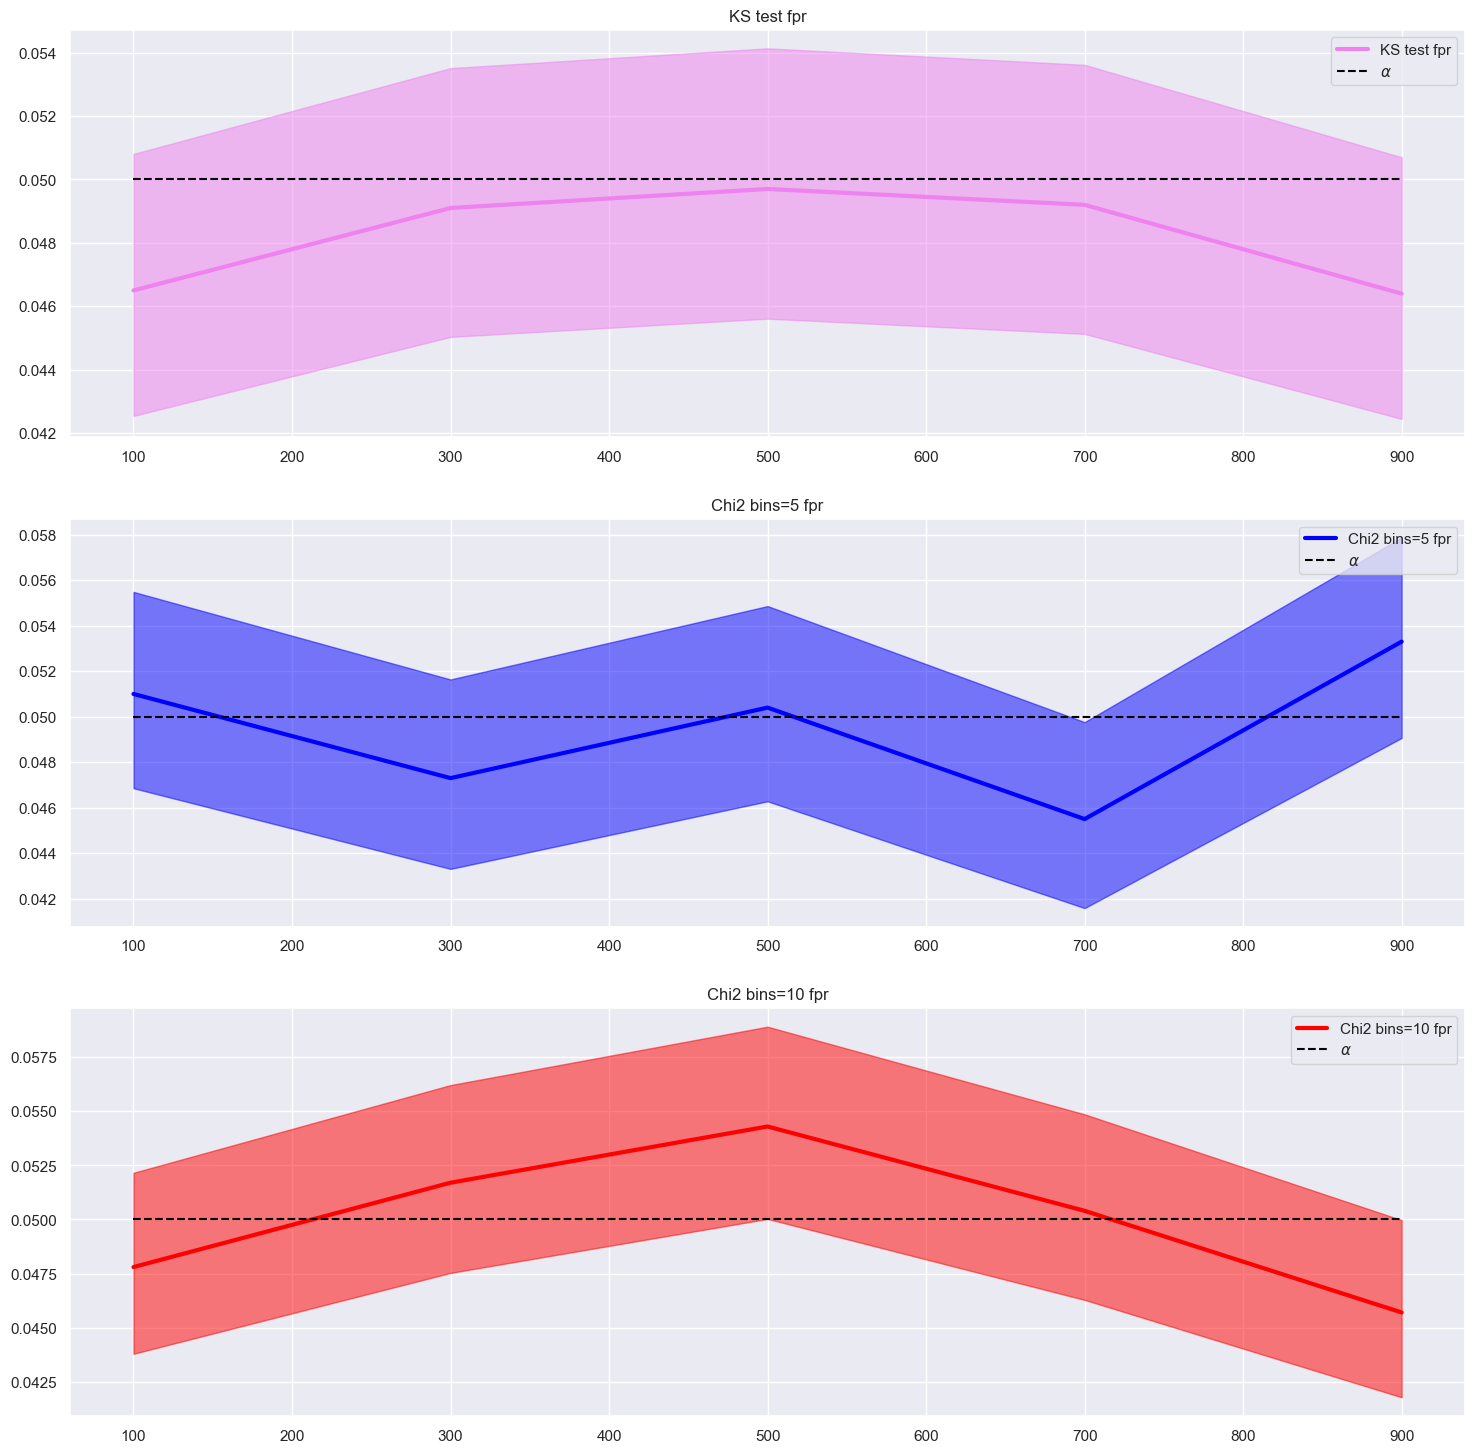

In [61]:
fig, ax = plt.subplots(nrows=3, figsize=(18, 18))

fpr_results = [FPR_list_ks, FPR_list_chi_sq_5_bins, FPR_list_chi_sq_10_bins]
titles = ['KS test fpr', 'Chi2 bins=5 fpr', 'Chi2 bins=10 fpr']
colors = ['violet', 'blue', 'red']

for i in range(3):
    ax[i].plot(
        [elem[0] for elem in fpr_results[i]],
        [elem[1][0] for elem in fpr_results[i]],
        linewidth=3.0,
        color=colors[i],
        label=titles[i]
    )
    ax[i].fill_between(
        [elem[0] for elem in fpr_results[i]],
        [elem[1][1] for elem in fpr_results[i]],
        [elem[1][2] for elem in fpr_results[i]],
        color=colors[i],
        alpha=0.5
    )
    ax[i].plot(
        [elem[0] for elem in fpr_results[i]],
        [0.05] * len(fpr_results[i]),
        color='black',
        linestyle='--',
        label=r'$\alpha$'
    )
    ax[i].legend()
    ax[i].set_title(titles[i])

In [62]:
dist = expon(3)

FPR_list_ks = []
FPR_list_chi_sq_5_bins = []
FPR_list_chi_sq_10_bins = []

for i in tqdm((100, 300, 500, 700, 900)):
    ks_res = check_criterion(
        sample_size=i,
        sample_dist=dist,
        check_dist=dist,
        crit=ks_for_check
    )
    FPR_list_ks.append([i, ks_res])

    chi_sq_5_res = check_criterion_continuous(
        sample_size=i,
        bins_amount=5,
        sample_dist=dist,
        check_dist=dist,
        crit=chisquare_for_continuos
    )
    FPR_list_chi_sq_5_bins.append([i, chi_sq_5_res])

    chi_sq_10_res = check_criterion_continuous(
        sample_size=i,
        bins_amount=10,
        sample_dist=dist,
        check_dist=dist,
        crit=chisquare_for_continuos
    )
    FPR_list_chi_sq_10_bins.append([i, chi_sq_10_res])

100%|██████████| 5/5 [01:30<00:00, 18.14s/it]


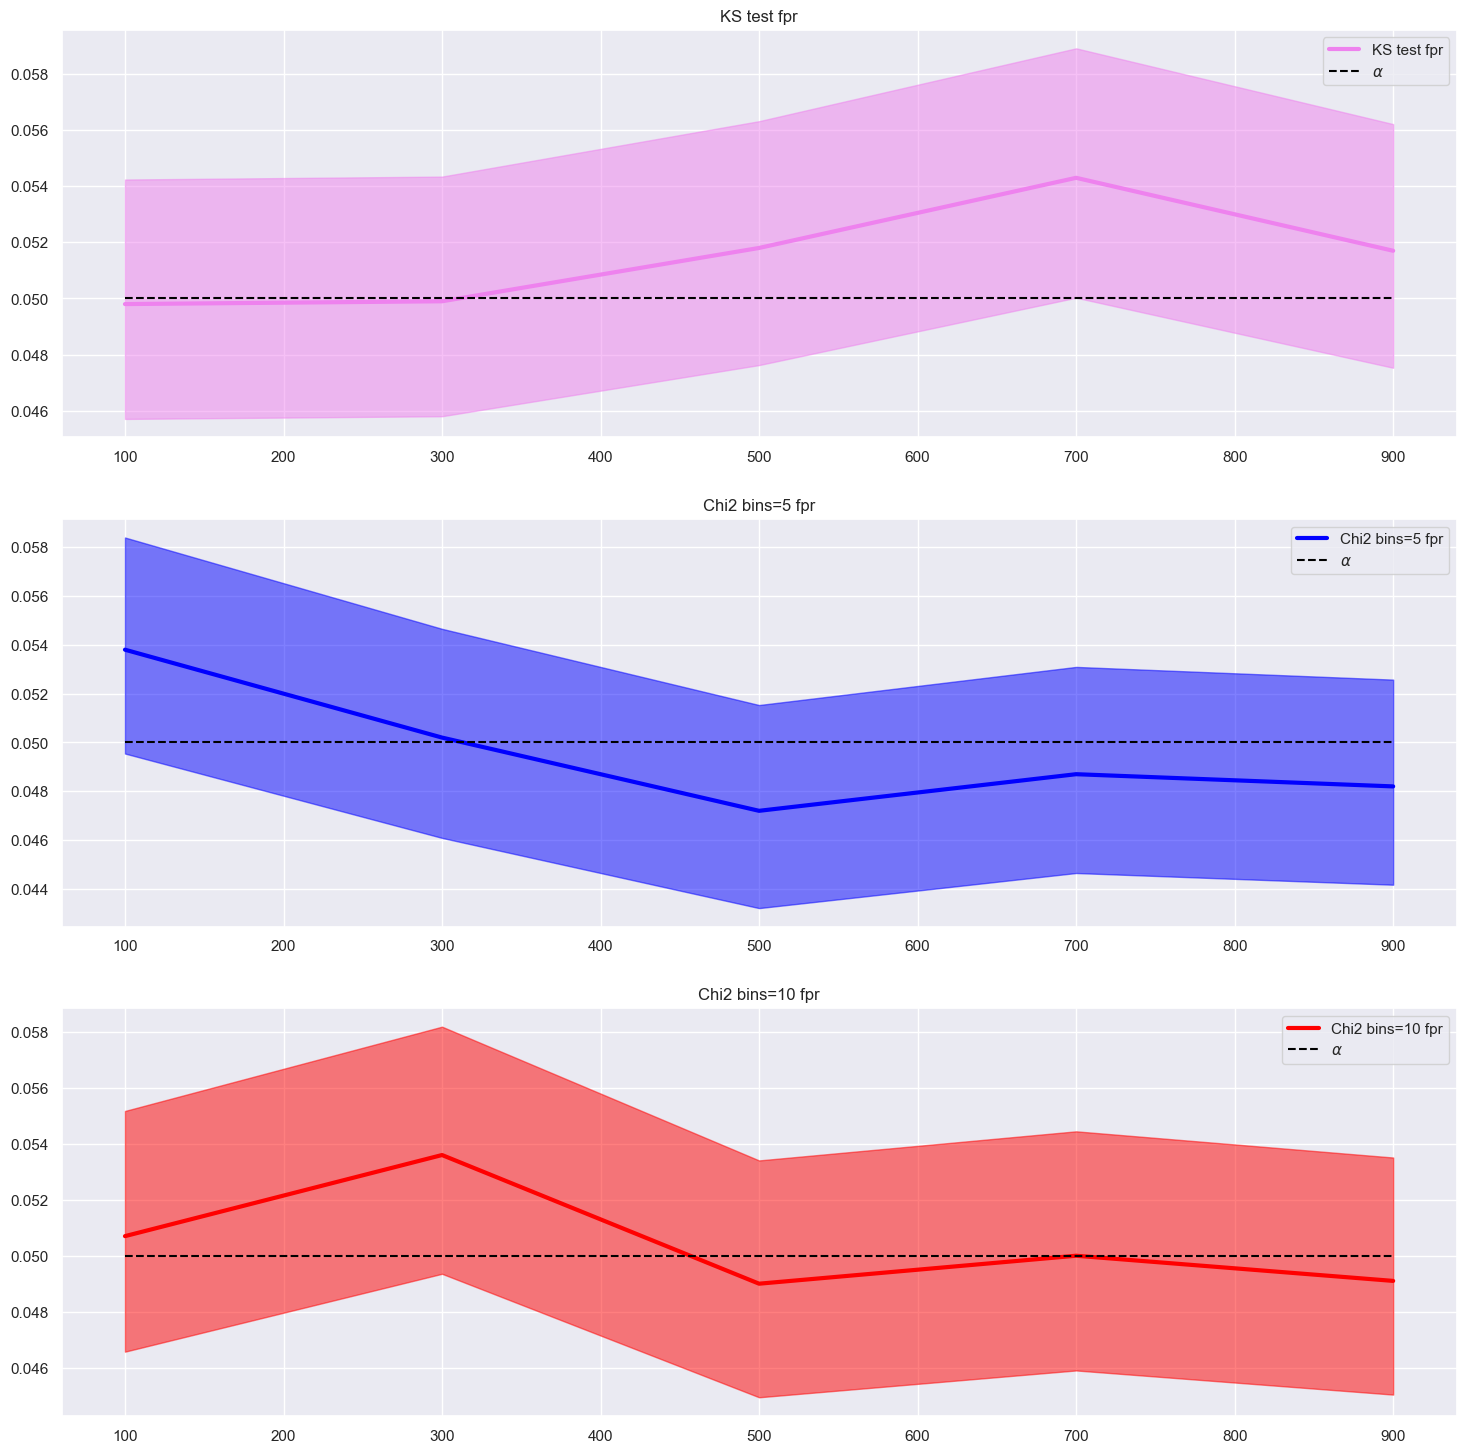

In [63]:
fig, ax = plt.subplots(nrows=3, figsize=(18, 18))

fpr_results = [FPR_list_ks, FPR_list_chi_sq_5_bins, FPR_list_chi_sq_10_bins]
titles = ['KS test fpr', 'Chi2 bins=5 fpr', 'Chi2 bins=10 fpr']
colors = ['violet', 'blue', 'red']

for i in range(3):
    ax[i].plot(
        [elem[0] for elem in fpr_results[i]],
        [elem[1][0] for elem in fpr_results[i]],
        linewidth=3.0,
        color=colors[i],
        label=titles[i]
    )
    ax[i].fill_between(
        [elem[0] for elem in fpr_results[i]],
        [elem[1][1] for elem in fpr_results[i]],
        [elem[1][2] for elem in fpr_results[i]],
        color=colors[i],
        alpha=0.5
    )
    ax[i].plot(
        [elem[0] for elem in fpr_results[i]],
        [0.05] * len(fpr_results[i]),
        color='black',
        linestyle='--',
        label=r'$\alpha$'
    )
    ax[i].legend()
    ax[i].set_title(titles[i])

Итак, все критерии показывают одинаковый уровень стат значимости, тогда надо сравнивать мощности

In [64]:
TPR_list_ks = []
TPR_list_chi_sq_5_bins = []
TPR_list_chi_sq_10_bins = []

sample_dist = norm(0.2, 1)
check_dist = norm(0, 1)

for i in tqdm((100, 300, 500, 700, 900)):
    ks_res = check_criterion(
        sample_size=i,
        sample_dist=sample_dist,
        check_dist=check_dist,
        crit=ks_for_check
    )
    TPR_list_ks.append([i, ks_res])

    chi_sq_5_res = check_criterion_continuous(
        sample_size=i,
        bins_amount=5,
        sample_dist=sample_dist,
        check_dist=check_dist,
        crit=chisquare_for_continuos
    )
    TPR_list_chi_sq_5_bins.append([i, chi_sq_5_res])

    chi_sq_10_res = check_criterion_continuous(
        sample_size=i,
        bins_amount=10,
        sample_dist=sample_dist,
        check_dist=check_dist,
        crit=chisquare_for_continuos
    )
    TPR_list_chi_sq_10_bins.append([i, chi_sq_10_res])

  0%|          | 0/10000 [00:00<?, ?it/s]

100%|██████████| 5/5 [01:51<00:00, 22.39s/it]


Text(0.5, 1.0, 'Tests power ')

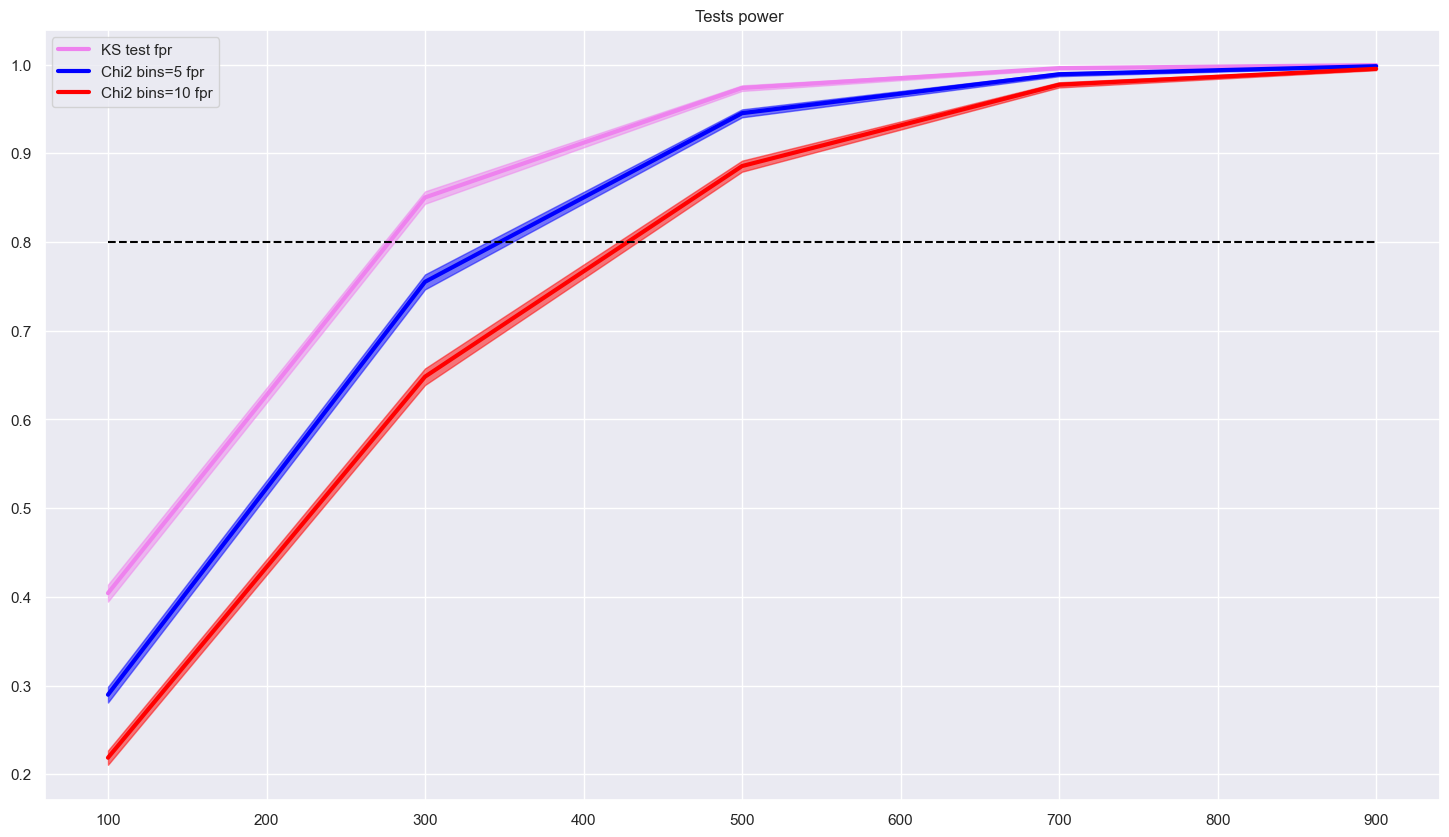

In [65]:
fig, ax = plt.subplots(figsize=(18, 10))

fpr_results = [TPR_list_ks, TPR_list_chi_sq_5_bins, TPR_list_chi_sq_10_bins]
titles = ['KS test fpr', 'Chi2 bins=5 fpr', 'Chi2 bins=10 fpr']
colors = ['violet', 'blue', 'red']

for i in range(3):
    ax.plot(
        [elem[0] for elem in fpr_results[i]],
        [elem[1][0] for elem in fpr_results[i]],
        linewidth=3.0,
        color=colors[i],
        label=titles[i]
    )
    ax.fill_between(
        [elem[0] for elem in fpr_results[i]],
        [elem[1][1] for elem in fpr_results[i]],
        [elem[1][2] for elem in fpr_results[i]],
        color=colors[i],
        alpha=0.5
    )
ax.plot(
    [elem[0] for elem in fpr_results[0]],
    [0.8] * len(fpr_results[0]),
    color='black',
    linestyle='--'
)
ax.legend()
ax.set_title('Tests power ')

In [68]:
TPR_list_ks = []
TPR_list_chi_sq_5_bins = []
TPR_list_chi_sq_10_bins = []

sample_dist = expon(3.1)
check_dist = expon(3)

for i in tqdm((100, 300, 500, 700, 900)):
    ks_res = check_criterion(
        sample_size=i,
        sample_dist=sample_dist,
        check_dist=check_dist,
        crit=ks_for_check
    )
    TPR_list_ks.append([i, ks_res])

    chi_sq_5_res = check_criterion_continuous(
        sample_size=i,
        bins_amount=5,
        sample_dist=sample_dist,
        check_dist=check_dist,
        crit=chisquare_for_continuos
    )
    TPR_list_chi_sq_5_bins.append([i, chi_sq_5_res])

    chi_sq_10_res = check_criterion_continuous(
        sample_size=i,
        bins_amount=10,
        sample_dist=sample_dist,
        check_dist=check_dist,
        crit=chisquare_for_continuos
    )
    TPR_list_chi_sq_10_bins.append([i, chi_sq_10_res])

100%|██████████| 5/5 [01:59<00:00, 23.90s/it]


Text(0.5, 1.0, 'Tests power ')

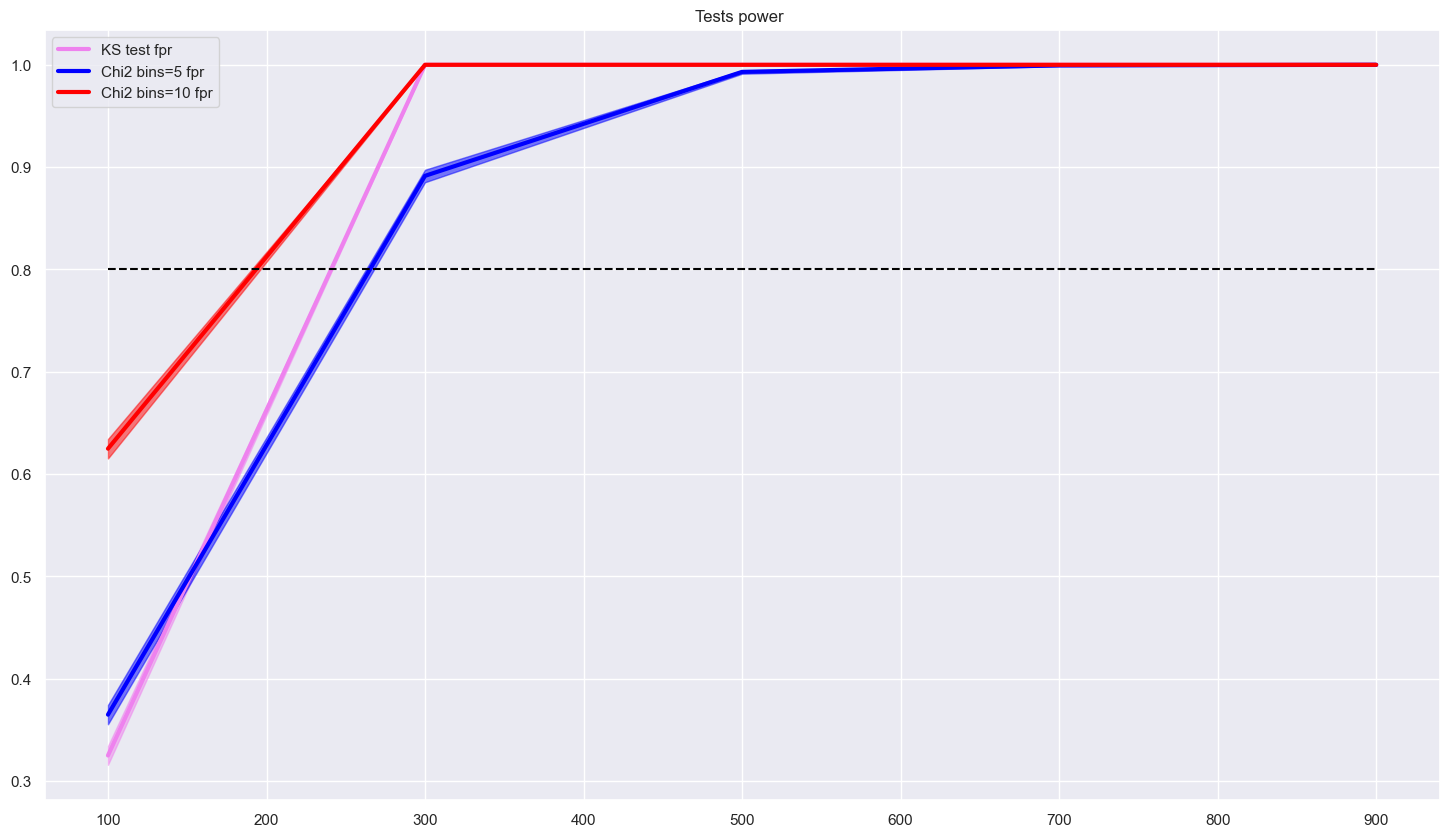

In [69]:
fig, ax = plt.subplots(figsize=(18, 10))

fpr_results = [TPR_list_ks, TPR_list_chi_sq_5_bins, TPR_list_chi_sq_10_bins]
titles = ['KS test fpr', 'Chi2 bins=5 fpr', 'Chi2 bins=10 fpr']
colors = ['violet', 'blue', 'red']

for i in range(3):
    ax.plot(
        [elem[0] for elem in fpr_results[i]],
        [elem[1][0] for elem in fpr_results[i]],
        linewidth=3.0,
        color=colors[i],
        label=titles[i]
    )
    ax.fill_between(
        [elem[0] for elem in fpr_results[i]],
        [elem[1][1] for elem in fpr_results[i]],
        [elem[1][2] for elem in fpr_results[i]],
        color=colors[i],
        alpha=0.5
    )
ax.plot(
    [elem[0] for elem in fpr_results[0]],
    [0.8] * len(fpr_results[0]),
    color='black',
    linestyle='--'
)
ax.legend()
ax.set_title('Tests power ')

Для сдвинутого нормального распределения мощность вше у теста Колмогорова, потом идёт хи-квадрат с 5 корзинами, а потом уже с 10. Для экспоненциального распределения лучше всего работает хи-квадрат с 1- корзинами. В общем, в очередной раз убеждаемся, что надо использовать Монте-Карло для валидации теста.

Посмотрим ещё на случай растянутого нормального, и случай сдвинутого+растянутого

In [70]:
TPR_list_ks = []
TPR_list_chi_sq_5_bins = []
TPR_list_chi_sq_10_bins = []

sample_dist = norm(0, 1.1)
check_dist = norm(0, 1)

for i in tqdm((100, 300, 500, 700, 900)):
    ks_res = check_criterion(
        sample_size=i,
        sample_dist=sample_dist,
        check_dist=check_dist,
        crit=ks_for_check
    )
    TPR_list_ks.append([i, ks_res])

    chi_sq_5_res = check_criterion_continuous(
        sample_size=i,
        bins_amount=5,
        sample_dist=sample_dist,
        check_dist=check_dist,
        crit=chisquare_for_continuos
    )
    TPR_list_chi_sq_5_bins.append([i, chi_sq_5_res])

    chi_sq_10_res = check_criterion_continuous(
        sample_size=i,
        bins_amount=10,
        sample_dist=sample_dist,
        check_dist=check_dist,
        crit=chisquare_for_continuos
    )
    TPR_list_chi_sq_10_bins.append([i, chi_sq_10_res])

100%|██████████| 5/5 [01:22<00:00, 16.59s/it]


Text(0.5, 1.0, 'Tests power ')

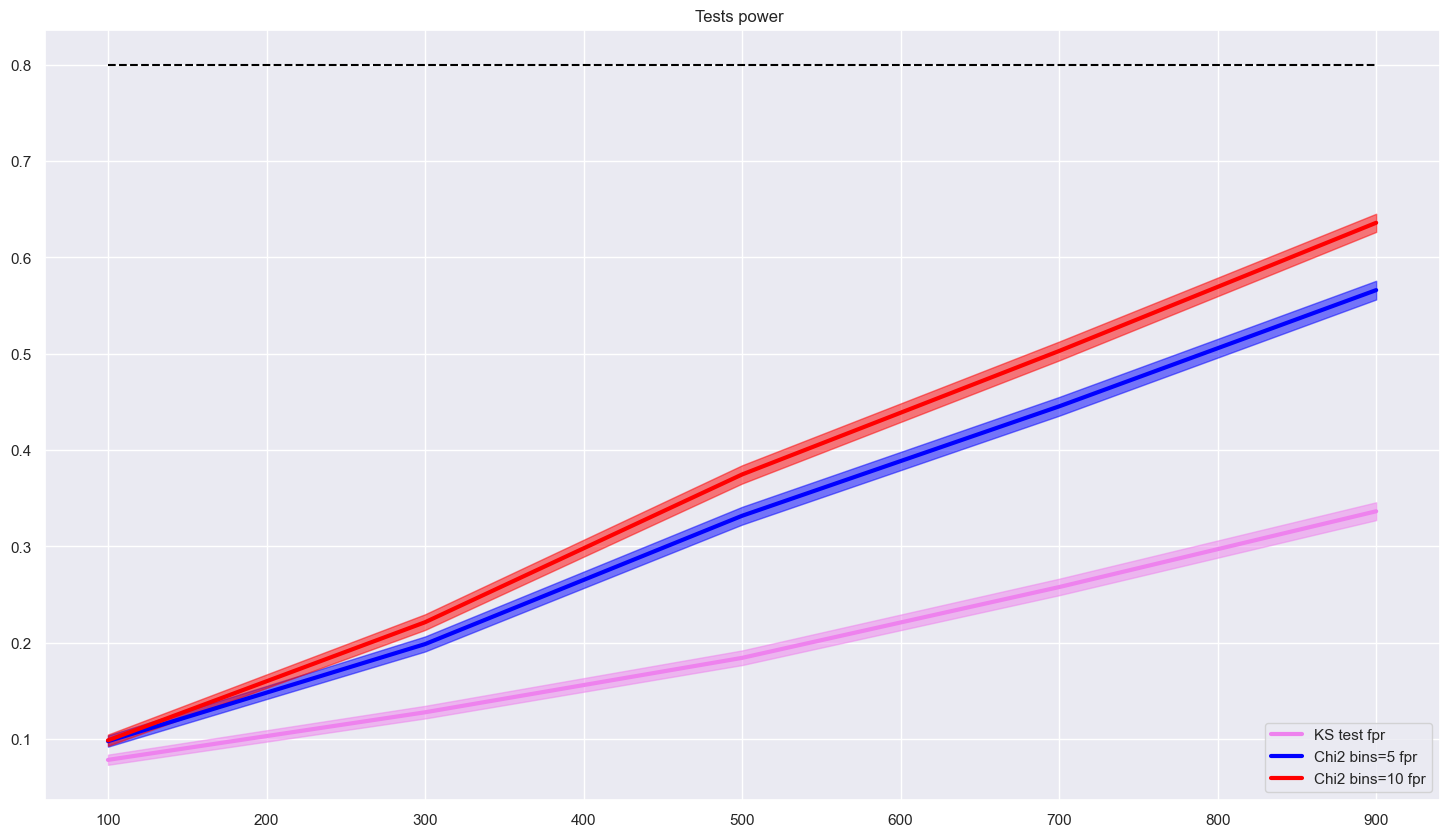

In [71]:
fig, ax = plt.subplots(figsize=(18, 10))

fpr_results = [TPR_list_ks, TPR_list_chi_sq_5_bins, TPR_list_chi_sq_10_bins]
titles = ['KS test fpr', 'Chi2 bins=5 fpr', 'Chi2 bins=10 fpr']
colors = ['violet', 'blue', 'red']

for i in range(3):
    ax.plot(
        [elem[0] for elem in fpr_results[i]],
        [elem[1][0] for elem in fpr_results[i]],
        linewidth=3.0,
        color=colors[i],
        label=titles[i]
    )
    ax.fill_between(
        [elem[0] for elem in fpr_results[i]],
        [elem[1][1] for elem in fpr_results[i]],
        [elem[1][2] for elem in fpr_results[i]],
        color=colors[i],
        alpha=0.5
    )
ax.plot(
    [elem[0] for elem in fpr_results[0]],
    [0.8] * len(fpr_results[0]),
    color='black',
    linestyle='--'
)
ax.legend()
ax.set_title('Tests power ')

In [74]:
TPR_list_ks = []
TPR_list_chi_sq_5_bins = []
TPR_list_chi_sq_10_bins = []

sample_dist = norm(0.2, 1.1)
check_dist = norm(0, 1)

for i in tqdm((100, 300, 500, 700, 900)):
    ks_res = check_criterion(
        sample_size=i,
        sample_dist=sample_dist,
        check_dist=check_dist,
        crit=ks_for_check
    )
    TPR_list_ks.append([i, ks_res])

    chi_sq_5_res = check_criterion_continuous(
        sample_size=i,
        bins_amount=5,
        sample_dist=sample_dist,
        check_dist=check_dist,
        crit=chisquare_for_continuos
    )
    TPR_list_chi_sq_5_bins.append([i, chi_sq_5_res])

    chi_sq_10_res = check_criterion_continuous(
        sample_size=i,
        bins_amount=10,
        sample_dist=sample_dist,
        check_dist=check_dist,
        crit=chisquare_for_continuos
    )
    TPR_list_chi_sq_10_bins.append([i, chi_sq_10_res])

100%|██████████| 5/5 [01:39<00:00, 19.99s/it]


Text(0.5, 1.0, 'Tests power ')

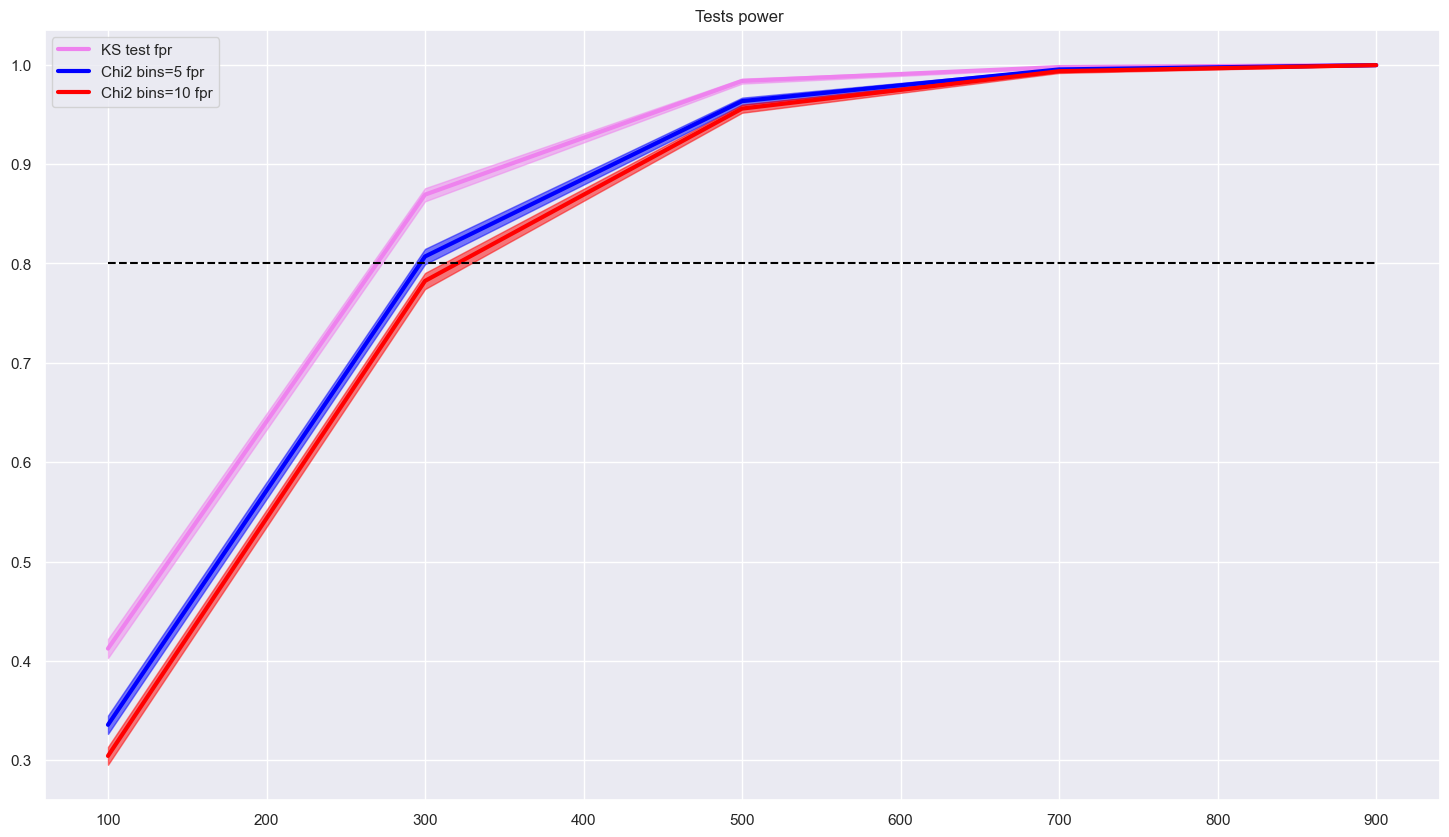

In [75]:
fig, ax = plt.subplots(figsize=(18, 10))

fpr_results = [TPR_list_ks, TPR_list_chi_sq_5_bins, TPR_list_chi_sq_10_bins]
titles = ['KS test fpr', 'Chi2 bins=5 fpr', 'Chi2 bins=10 fpr']
colors = ['violet', 'blue', 'red']

for i in range(3):
    ax.plot(
        [elem[0] for elem in fpr_results[i]],
        [elem[1][0] for elem in fpr_results[i]],
        linewidth=3.0,
        color=colors[i],
        label=titles[i]
    )
    ax.fill_between(
        [elem[0] for elem in fpr_results[i]],
        [elem[1][1] for elem in fpr_results[i]],
        [elem[1][2] for elem in fpr_results[i]],
        color=colors[i],
        alpha=0.5
    )
ax.plot(
    [elem[0] for elem in fpr_results[0]],
    [0.8] * len(fpr_results[0]),
    color='black',
    linestyle='--'
)
ax.legend()
ax.set_title('Tests power ')

В итоге, судя по всему, Колмогоров побеждает когда есть сдвиг, но проигрывает когда есть изменение дисперсии (вероятно, это связано с тем, что при изменении дисперсии у эмпирической ф.р. аргумент x заменяется на аргумент $\frac{x}{\sigma}$, где $\sigma$ - изменение дисперсии (не очень формально, но если расписать то понятно), а учитывая что мы считаем статистику критерия Колмогорова в точках выборки, которые можно представить как $\sigma X_k$, где $X_k$ из проверяемой выборки, значение эмпирической функции распределения не сильно изменится)

***Проверка сложной гипотезы с помощью хи-квадрат критерия***

Как и в критерии Колмогорова будем использовать следующую идея: оценим параметры распределения на выборке (вообще, используем метод максимального правдоподобия, но в некоторых случаях его можно заменить методом моментов)

Но в этот раз у нас, в отличии от критерия Колмогорова, есть универсальная теорема (а не частные решения, вроде поправки Лиллиефорса): если проверяется сложная гипотеза с $k$ исходами, и оценивается $v$ параметрами методом максимального правдоподобия, то статистика $\tau$ в пределе имеет распределение $\chi^2_{k-v-1}$ 

Оценка максимального правдоподобия: без подробных объяснений это следующая вещь$${\displaystyle {\hat {\theta }}_{\mathrm {M\Pi } }={\hat {\theta }}_{\mathrm {M\Pi } }(X_{1},\ldots ,X_{n})=\mathop {\rm {argmax}} \limits _{\theta \in \Theta }\sum _{i=1}^{n}ln(P(X = X_i|\theta))}$$

Хорошая новость: для нормального распределения выборочное среднее и дисперсия являются оценкой, полученной методом максимального правдоподобия, что может помочь при работе с некоторыми гипотезами

Итак, можем составить следующий алгоритм для проверки сложной гипотезы

1. Фиксируем уровень значимости $\alpha$.
2. Фиксируем семейство $v$-параметрических дискретных распределений $\mathcal{P}$, на принадлежность к которому мы хотим проверить нашу выборку.
3. Записываем выборку с $k$ исходами в виде frequency table.
4. Если в ячейке таблицы стоит число <5 (либо <10 для случая frequency table 2x1), то объединяем исходы до тех пор, пока это условие не будет выполнено.
5. По выборке оцениваем $v$ параметров с помощью ОМП.
6. Рассчитываем статистику $$\tau = n\sum_{i=1}^k\frac{\left(\frac{n_i}{n}-p_i\right)^2}{p_i},$$
где $n$ - размер выборки, $k$ - число различных исходов, $n_i$ - число выпадений исхода $i$, $p_i$ - вероятность исхода $i$ согласно распределению $\mathcal{P}$ с оцененными параметрами.
7. Считаем $\it{\text{p-value}}$ как $P(X \geq \tau)$, где $X \sim \chi^2_{k-v-1}$.
8. Если $\it{\text{p-value}} \leq \alpha$, то гипотезу отвергаем.

Условия применимости такие же, как для простой гипотезы:
- распределение дискретное;
- число наблюдений в каждой ячейке выше 5;
- для случая frequency table 2x1 число наблюдений в каждой ячейке выше 10.

***Критерии независимости и однородности $\chi^2$***

Метод хи-квадрат Пирсона позволяет ответить на вопрос о независимости случайных величин   
$$H_0: \text{ случайные величины } \phi \text{ и } \eta \text{ независимы.}$$
$$H_1: \text{не } H_0$$

составляем таблицу частот, которая выглядит примерно так  
| |$$<1 \text{ года}$$|$$1 - 2 \text{ года}$$|$$2-3 \text{ года}$$|$$3-4 \text{ года}$$|$$4-5 \text{ лет}$$|$$5+ \text{ лет}$$|
|---|---|---|---|---|---|---|
|$\leq 9 \text{ посещений}$|$n_{11}$|$n_{12}$|$n_{13}$|$n_{14}$|$n_{15}$|$n_{16}$|
|$10-19 \text{ посещений}$|$n_{21}$|$n_{22}$|$n_{23}$|$n_{24}$|$n_{25}$|$n_{26}$|
|$20-29 \text{ посещений}$|$n_{31}$|$n_{32}$|$n_{33}$|$n_{34}$|$n_{35}$|$n_{36}$|
|$30+ \text{ посещений}$|$n_{41}$|$n_{42}$|$n_{43}$|$n_{44}$|$n_{45}$|$n_{46}$|

Давайте запишем критерий в качестве алгоритма:

1. Фиксируем уровень значимости $\alpha$.
2. Записываем $m$ выборок с $k$ исходами в виде contingency table.
3. Если в ячейке таблицы стоит число <5 (либо <10 для случая contingency table 2x2), то объединяем исходы до тех пор, пока это условие не будет выполнено.
4. Рассчитываем статистику $$\tau = n\sum_{i=1, j=1}^{i=m, j=k}\frac{\left(\frac{n_{ji}}{n}-q_i p_j\right)^2}{q_i p_j},$$
где $m$ - число выборок, $k$ - число исходов в них, а $q_i$ и $p_i$ - оценки вероятности исходов вида $\phi = i, \eta = j$.
5. Считаем *p-value* как $P(X \geq \tau)$, где $X \sim \chi^2_{(m-1)(k-1)}$.
6. Если *p-value* $\leq \alpha$, то гипотезу отвергаем.

Условия применимости:
- распределение дискретное;
- число наблюдений в каждой ячейке выше 5;
- для случая contingency table 2x2 число наблюдений в каждой ячейке выше 10.

Для проверки такой гипотезы есть функция scipy.stats.chi2_contingency (писать тест для проверки впадлу)

Этим же приёмом можно проверять гипотезу однородности для дискретных случайных величин, просто составляем таблицу частотности (ячейки - сколько раз одновременно происходит событие $\phi = i$ и $\psi = j$), и теперь задача однородности эквивалентна прошлой задаче независимости

По умолчанию в chi2_contingency включена поправка Йетса, из-за которой формула выглядит следующим образом  
$$\tau = n\sum_{i=1, j=1}^{i=2, j=2}\frac{(\frac{n_{ji}}{n}-q_i p_j - 0.5)^2}{q_i p_j},$$

Её иожно выключить, задав аргумент correction=False

In [43]:
chi2_contingency(observed=[[15, 18], [15,13]], correction=False)

Chi2ContingencyResult(statistic=0.3992982823627989, pvalue=0.5274518757044919, dof=1, expected_freq=array([[16.2295082, 16.7704918],
       [13.7704918, 14.2295082]]))

In [44]:
chi2_contingency(observed=[[15, 18], [15, 13]], correction=True)

Chi2ContingencyResult(statistic=0.1405707419820326, pvalue=0.7077142755628698, dof=1, expected_freq=array([[16.2295082, 16.7704918],
       [13.7704918, 14.2295082]]))